In [423]:
%reset

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras import layers
from keras.models import Sequential
import pandas as pd
import numpy as np

import random
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import matplotlib.ticker as ticker

import numpy as np
import pandas as pd

import time
import math

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [424]:
# Helper functions to track time elapsed and remaining.
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# not used thus far
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

# Plot results
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    
# Precision = TP / (TP+FP).
def find_precision(decoded_vals, target_vals):
    TP = 0
    FP = 0
    for i in range(len(decoded_vals)):
        TP += int(decoded_vals[i] == 1 and target_vals.iloc[i] == 1)
        FP += int(decoded_vals[i] == 1 and target_vals.iloc[i] == 0)

    return 1.0 * TP / (TP + FP)

# Recall = TP / (TP+FN).
def find_recall(decoded_vals, target_vals):
    TP = 0
    FN = 0
    for i in range(len(decoded_vals)):
        TP += int(decoded_vals[i] == 1 and target_vals.iloc[i] == 1)
        FN += int(decoded_vals[i] == 0 and target_vals.iloc[i] == 1)

    return 1.0 * TP / (TP + FN)

# Recall = (TP + TN) / 2.
def find_balanced_accuracy(decoded_vals, target_vals):
    P = 0
    TP = 0
    N = 0
    TN = 0
    for i in range(len(decoded_vals)):
        P += int(target_vals.iloc[i] == 1)
        TP += int(decoded_vals[i] == 1 and target_vals.iloc[i] == 1)
        N += int(target_vals.iloc[i] == 0)
        TN += int(decoded_vals[i] == 0 and target_vals.iloc[i] == 0)
    
    return (TP/P + TN/N)/2.0

In [425]:
data_input = pd.read_csv('drugbank_smile_data_with_adrs.csv')
data_source = []
for index, drug in data_input.iterrows():
    if drug['approved'] == 1:
        data_source.append(drug)
    elif drug['illicit'] == 1 or drug['withdrawn'] == 1: 
        data_source.append(drug)
data_source_filter = pd.DataFrame(data_source)
data_source_filter

,approved,drug_id,experimental,illicit,investigational,name,nutraceutical,smile,vet_approved,withdrawn,adrs
0,1,DB00006,0,0,1,Bivalirudin,0,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,0,0,"14, 08, 13, 10, 21, 03, 02, 24, 19, 01, 17, 11..."
1,1,DB00014,0,0,0,Goserelin,0,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,0,0,"21, 03, 24, 17, 25, 07, 08, 26, 16, 09, 22, 23..."
2,1,DB00027,0,0,0,Gramicidin D,0,CC(C)C[C@@H](NC(=O)CNC(=O)[C@@H](NC=O)C(C)C)C(...,0,0,NaN
3,1,DB00035,0,0,0,Desmopressin,0,NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...,0,0,"21, 24, 17, 25, 07, 08, 26, 22, 23, 13, 12, 14..."
4,1,DB00050,0,0,1,Cetrorelix,0,CC(C)C[C@H](NC(=O)[C@@H](CCCNC(N)=O)NC(=O)[C@H...,0,0,"21, 03, 24, 17, 25, 07, 08, 16, 09, 22, 23, 13..."
...,...,...,...,...,...,...,...,...,...,...,...
10182,1,DB14725,0,0,0,Cefamandole nafate,0,[H][C@]12SCC(CSC3=NN=NN3C)=C(N1C(=O)[C@H]2NC(=...,0,0,NaN
10193,1,DB00781,0,0,0,Polymyxin B,0,[H][C@]1(NC(=O)[C@H](CCN)NC(=O)[C@H](CCN)NC(=O...,1,0,NaN
10196,1,DB14753,0,0,0,Hydroxystilbamidine,0,NC(=N)C1=CC=C(\C=C\C2=C(O)C=C(C=C2)C(N)=N)C=C1,0,0,NaN
10197,1,DB14754,0,0,0,Solriamfetol,0,N[C@@H](COC(N)=O)CC1=CC=CC=C1,0,0,NaN


In [426]:
# creating dataset, using train/test split and try to predict 
corpus = []
for index, row in data_source_filter.iterrows():
    corpus.append(str(row['smile']))

vectorizer = CountVectorizer(analyzer='char')
X = vectorizer.fit_transform(corpus)
columns = vectorizer.get_feature_names()
featureList = X.toarray()
word_bag_df = []

for index, features in enumerate(featureList): 
    result = data_source_filter.iloc[index]['approved']
    a = np.append(features, result)
    word_bag_df.append(a)
word_bag_df = pd.DataFrame(word_bag_df)
word_bag_df

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
0,0,0,42,42,0,0,0,0,0,12,...,0,0,0,0,0,0,0,0,0,1
1,0,0,23,23,0,0,0,0,0,10,...,0,0,0,0,0,0,0,0,0,1
2,0,0,35,35,0,0,0,0,0,8,...,0,0,0,0,0,0,0,0,0,1
3,0,0,17,17,0,0,0,0,0,4,...,0,0,2,0,0,0,0,0,0,1
4,0,0,25,25,0,0,0,0,0,10,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2626,0,0,6,6,0,0,0,0,0,4,...,0,0,2,0,0,0,0,0,0,1
2627,0,0,24,24,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,1
2628,0,0,5,5,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,1
2629,0,0,2,2,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,1


# SkLearn Implementation as a First Pass

Here, we run high-level tests with various classifiers to check which one would be most effective as our baseline value. We find that the MLP is an effective first pass, and continue with that one as our model. Due to the limitations and the need to focus our paper, we only use one of the best models from below as one of our models. 

In [427]:
X_train, X_test, y_train, y_test = train_test_split(word_bag_df.iloc[:, 0:-1], word_bag_df.iloc[:, -1], train_size=0.85, test_size=0.15, shuffle=True)

clf = RandomForestClassifier(max_depth=60, n_estimators=60, random_state=7)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(np.mean(y_test == 1), np.mean(y_pred == 1))
np.mean(y_test == y_pred)

pred_test_rounded = np.round(y_pred)

precision_out = find_precision(pred_test_rounded, y_test)
recall_out = find_recall(pred_test_rounded, y_test)
balanced_accuracy = find_balanced_accuracy(pred_test_rounded, y_test)
print("Testing Precision: {:.4f}".format(precision_out))
print("Testing Recall: {:.4f}".format(recall_out))
print("Testing Average Precison/Recall: {:.4f}".format(balanced_accuracy))

0.9063291139240506 0.9493670886075949
Testing Precision: 0.9387
Testing Recall: 0.9832
Testing Average Precison/Recall: 0.6808


In [428]:
X_train, X_test, y_train, y_test = train_test_split(word_bag_df.iloc[:, 0:-1], word_bag_df.iloc[:, -1], train_size=0.85, test_size=0.15, shuffle=True)

clfLog = LogisticRegression(solver='lbfgs')
clfLog.fit(X_train, y_train)
y_pred = clfLog.predict(X_test)

print(np.mean(y_test == 1), np.mean(y_pred == 1))
np.mean(y_test == y_pred)

pred_test_rounded = np.round(y_pred)

precision_out = find_precision(pred_test_rounded, y_test)
recall_out = find_recall(pred_test_rounded, y_test)
balanced_accuracy = find_balanced_accuracy(pred_test_rounded, y_test)
print("Testing Precision: {:.4f}".format(precision_out))
print("Testing Recall: {:.4f}".format(recall_out))
print("Testing Balanced Average: {:.4f}".format(balanced_accuracy))

0.9139240506329114 1.0
Testing Precision: 0.9139
Testing Recall: 1.0000
Testing Balanced Average: 0.5000


/Users/dylanli/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [429]:
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(word_bag_df.iloc[:, 0:-1], word_bag_df.iloc[:, -1], train_size=0.85, test_size=0.15, shuffle=True)

clfLog = SVC()
clfLog.fit(X_train, y_train)
y_pred = clfLog.predict(X_test)

pred_test_rounded = np.round(y_pred)

print(np.mean(y_test == 1), np.mean(y_pred == 1))
np.mean(y_test == y_pred)

precision_out = find_precision(pred_test_rounded, y_test)
recall_out = find_recall(pred_test_rounded, y_test)
balanced_accuracy = find_balanced_accuracy(pred_test_rounded, y_test)
print("Testing Precision: {:.4f}".format(precision_out))
print("Testing Recall: {:.4f}".format(recall_out))
print("Testing Average Precison/Recall: {:.4f}".format(balanced_accuracy))

0.9139240506329114 0.9772151898734177
Testing Precision: 0.9249
Testing Recall: 0.9889
Testing Average Precison/Recall: 0.5680


/Users/dylanli/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [430]:
X_train_MLP, X_test_MLP, y_train_MLP, y_test_MLP = train_test_split(word_bag_df.iloc[:, 0:-1], word_bag_df.iloc[:, -1], train_size=0.85, test_size=0.15, shuffle=True)

MLP = MLPClassifier(hidden_layer_sizes=(50, 40, 30, 20), learning_rate='adaptive', solver='adam', max_iter=300)
MLP.fit(X_train_MLP, y_train_MLP)
y_pred_MLP= MLP.predict(X_test_MLP)

print(np.mean(y_test_MLP == 1), np.mean(y_pred_MLP == 1))
np.mean(y_test_MLP == y_pred_MLP)

pred_test_rounded = np.round(y_pred)

precision_out = find_precision(pred_test_rounded, y_test)
recall_out = find_recall(pred_test_rounded, y_test)
balanced_accuracy = find_balanced_accuracy(pred_test_rounded, y_test)
print("Testing Precision: {:.4f}".format(precision_out))
print("Testing Recall: {:.4f}".format(recall_out))
print("Testing Average Precison/Recall: {:.4f}".format(balanced_accuracy))

0.9063291139240506 0.959493670886076
Testing Precision: 0.9249
Testing Recall: 0.9889
Testing Average Precison/Recall: 0.5680


# Implementation in Keras
Using the best-performing model in our initial pass (the MLP) to be used with the bag-of-words implementation. We encode the sequences in the bag-of-words format and analyze and plot our results. Note that the accuracy tested per epoch is not the balanced accuracy, which is only tested at the end. 

In [431]:
from keras.models import Sequential
from sklearn.utils import class_weight
from keras import layers
from keras import optimizers

# data input layer
train_url = "https://raw.githubusercontent.com/vli1721/cs281-project/master/drugbank_smile_data_filtered_train.csv?token=AHRDF6OBWOFKKK4AKOCY2N257WWVE"
training_dataset = pd.read_csv(train_url, index_col=0)

test_url = "https://raw.githubusercontent.com/vli1721/cs281-project/master/drugbank_smile_data_filtered_test.csv?token=AHRDF6NISTEXL5L2SDWX4XS57WWOY"
testing_dataset = pd.read_csv(test_url,index_col=0)

print(training_dataset)
vectorizer = CountVectorizer(analyzer='char')

def encode_bag_of_words(dataset):
    print(dataset.shape)
    corpus = []
    # appending smile sequences 
    for index, row in dataset.iterrows():
        corpus.append(str(row['smile']))

    X = vectorizer.fit_transform(corpus)
    featureList = X.toarray()
    word_bag_df = []

    for index, features in enumerate(featureList): 
        result = int(dataset.iloc[index]['toxicity'] == 0)
        a = np.append(features, result)
        word_bag_df.append(a)
    word_bag_df = pd.DataFrame(word_bag_df)
    return word_bag_df

comb_dataset = pd.concat([training_dataset, testing_dataset], ignore_index=True)
encoded_train_test = encode_bag_of_words(comb_dataset)

X_train_nMLP, X_test_nMLP, y_train_nMLP, y_test_nMLP = train_test_split(
    encoded_train_test.iloc[:, 0:-1], encoded_train_test.iloc[:, -1], train_size=0.80, test_size=0.20, shuffle=False)

                          name  \
drug_id                          
DB13743  Sodium aurotiosulfate   
DB01409             Tiotropium   
DB14555               Ursadiol   
DB11255    Chromium picolinate   
DB01096            Oxamniquine   
...                        ...   
DB08884         Gadoxetic acid   
DB14200              Thiohexam   
DB06766            Alcaftadine   
DB09009              Articaine   
DB00979         Cyclopentolate   

                                                     smile  toxicity  
drug_id                                                               
DB13743  O.O.[Na+].[Na+].[Na+].[Au+].[O-]S([S-])(=O)=O....         0  
DB01409  [H][C@]12O[C@@]1([H])[C@]1([H])C[C@@]([H])(C[C...         0  
DB14555  [H][C@@]12CC[C@]3(C)[C@]([H])(CCC4=C5CC(C)(C)C...         0  
DB11255  O=C(O[Cr](OC(=O)C1=CC=CC=N1)OC(=O)C1=CC=CC=N1)...         0  
DB01096         CC(C)NCC1CCC2=CC(CO)=C(C=C2N1)[N+]([O-])=O         0  
...                                                    ...  

In [432]:
input_dim = X_train_nMLP.shape[1]

class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train_nMLP), y_train_nMLP)
class_weights_dict = dict(enumerate(class_weights))


# model considers dense layers with 50 layers trimming down to 20 layers, dropout
model = Sequential()
model.add(layers.Dense(50, input_dim=input_dim, activation='relu'))
model.add(layers.Dropout(0.35))
model.add(layers.Dense(40, activation='relu'))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'])
model.summary()

Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_485 (Dense)            (None, 50)                2350      
_________________________________________________________________
dropout_76 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_486 (Dense)            (None, 40)                2040      
_________________________________________________________________
dense_487 (Dense)            (None, 30)                1230      
_________________________________________________________________
dense_488 (Dense)            (None, 20)                620       
_________________________________________________________________
dense_489 (Dense)            (None, 1)                 21        
Total params: 6,261
Trainable params: 6,261
Non-trainable params: 0
___________________________________________________

In [433]:
%%time
history = model.fit(X_train_nMLP, y_train_nMLP,
                    epochs=150,
                    validation_data=(X_test_nMLP, y_test_nMLP),
                    batch_size=64, class_weight = class_weights_dict)
loss, accuracy = model.evaluate(X_train_nMLP, y_train_nMLP)
print("Training Accuracy: {:.4f}".format(accuracy))
loss_test, accuracy_test = model.evaluate(X_test_nMLP, y_test_nMLP)
print("Testing Accuracy:  {:.4f}".format(accuracy_test))

Train on 2104 samples, validate on 527 samples
Epoch 1/150
2104/2104 [==============================] - 0s 149us/step - loss: 0.7236 - accuracy: 0.5770 - val_loss: 0.7089 - val_accuracy: 0.4744
Epoch 2/150
2104/2104 [==============================] - 0s 25us/step - loss: 0.6616 - accuracy: 0.6326 - val_loss: 0.7257 - val_accuracy: 0.4364
Epoch 3/150
2104/2104 [==============================] - 0s 24us/step - loss: 0.6551 - accuracy: 0.6084 - val_loss: 0.6836 - val_accuracy: 0.5446
Epoch 4/150
2104/2104 [==============================] - 0s 23us/step - loss: 0.6378 - accuracy: 0.6046 - val_loss: 0.5973 - val_accuracy: 0.6376
Epoch 5/150
2104/2104 [==============================] - 0s 22us/step - loss: 0.6165 - accuracy: 0.6240 - val_loss: 0.7442 - val_accuracy: 0.4459
Epoch 6/150
2104/2104 [==============================] - 0s 21us/step - loss: 0.5965 - accuracy: 0.5936 - val_loss: 0.5659 - val_accuracy: 0.6357
Epoch 7/150
2104/2104 [==============================] - 0s 24us/step - loss

2104/2104 [==============================] - 0s 23us/step - loss: 0.4438 - accuracy: 0.6949 - val_loss: 0.5577 - val_accuracy: 0.6584
Epoch 57/150
2104/2104 [==============================] - 0s 24us/step - loss: 0.4349 - accuracy: 0.6830 - val_loss: 0.4806 - val_accuracy: 0.6888
Epoch 58/150
2104/2104 [==============================] - 0s 22us/step - loss: 0.4294 - accuracy: 0.7058 - val_loss: 0.4599 - val_accuracy: 0.7154
Epoch 59/150
2104/2104 [==============================] - 0s 23us/step - loss: 0.4303 - accuracy: 0.6934 - val_loss: 0.4814 - val_accuracy: 0.7040
Epoch 60/150
2104/2104 [==============================] - 0s 24us/step - loss: 0.4351 - accuracy: 0.6901 - val_loss: 0.4803 - val_accuracy: 0.6983
Epoch 61/150
2104/2104 [==============================] - 0s 24us/step - loss: 0.4176 - accuracy: 0.7191 - val_loss: 0.5594 - val_accuracy: 0.6603
Epoch 62/150
2104/2104 [==============================] - 0s 23us/step - loss: 0.4435 - accuracy: 0.6896 - val_loss: 0.4786 - val_a

Epoch 112/150
2104/2104 [==============================] - 0s 23us/step - loss: 0.3790 - accuracy: 0.7362 - val_loss: 0.5107 - val_accuracy: 0.7306
Epoch 113/150
2104/2104 [==============================] - 0s 23us/step - loss: 0.3664 - accuracy: 0.7529 - val_loss: 0.4898 - val_accuracy: 0.7381
Epoch 114/150
2104/2104 [==============================] - 0s 24us/step - loss: 0.3920 - accuracy: 0.7548 - val_loss: 0.6076 - val_accuracy: 0.6717
Epoch 115/150
2104/2104 [==============================] - 0s 21us/step - loss: 0.3744 - accuracy: 0.7386 - val_loss: 0.4644 - val_accuracy: 0.7609
Epoch 116/150
2104/2104 [==============================] - 0s 20us/step - loss: 0.3484 - accuracy: 0.7771 - val_loss: 0.4918 - val_accuracy: 0.7438
Epoch 117/150
2104/2104 [==============================] - 0s 20us/step - loss: 0.3740 - accuracy: 0.7505 - val_loss: 0.5475 - val_accuracy: 0.7097
Epoch 118/150
2104/2104 [==============================] - 0s 20us/step - loss: 0.3747 - accuracy: 0.7486 - val_

In [434]:
predicted_test = model.predict(X_test_nMLP)
pred_test_rounded = np.round(predicted_test)

total_correct = 0
total_samples = len(pred_test_rounded)

# checking the functionality of accuracy in keras 
for i in range(total_samples): 
    if pred_test_rounded[i][0] == y_test_nMLP.iloc[i]:
        total_correct += 1

# checking the number of prediction 1s in the ground truth testing data and the predicted test data
accuracy = total_correct/total_samples
print("Percentage of 1 predictions: " + str(np.mean(pred_test_rounded)))
print("Percentage of 1 actual: " + str(np.mean(y_test_nMLP)))

# call precision and recall functions to evaluate
precision_out = find_precision(pred_test_rounded, y_test_nMLP)
recall_out = find_recall(pred_test_rounded, y_test_nMLP)
balanced_accuracy = find_balanced_accuracy(pred_test_rounded, y_test_nMLP)
print("Testing Precision: {:.4f}".format(precision_out))
print("Testing Recall: {:.4f}".format(recall_out))
print("Testing Balanced Average : {:.4f}".format(balanced_accuracy))

Percentage of 1 predictions: 0.7324478
Percentage of 1 actual: 0.920303605313093
Testing Precision: 0.9741
Testing Recall: 0.7753
Testing Balanced Average : 0.7686


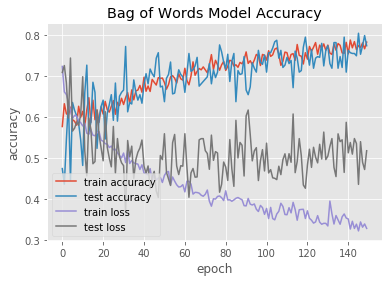

In [435]:
# plotting the bag of words model accuracy

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')

plt.title('Bag of Words Model Accuracy')
plt.legend(loc="lower left")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()